<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PAC3</p>
<p style="margin: 0; text-align:right;">2021-1 · Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación
</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 3: Métodos supervisados

En esta práctica veremos diferentes métodos supervisados y trataremos de optimizar diferentes métricas. Veremos cómo los diferentes modelos clasifican los puntos y con cuáles obtenemos mayor precisión. Después aplicaremos todo lo que hemos aprendido hasta ahora a un conjunto de datos nuevo simulando un caso práctico real.

1. Exploración de algoritmos supervisados
       1.2. K vecinos más cercanos
       1.3. Support vector machines
       1.4. Árbol de decisión
       1.5. Random forest
       1.5. Gradient boosting
2. Implementación de un caso práctico
       2.1. Análisis descriptivo
       2.2. Preprocesamiento de los datos
       2.3. Entrenamiento de un modeo
       2.4. Predicción de casos nuevos

**Importante: Cada uno de los ejercicios puede suponer varios minutos de ejecución, por lo que la entrega se ha de hacer en formato notebook y en formato html, donde se vea el código y los resultados junto con los comentarios de cada ejercicio. Para exportar el notebook a html se puede hacer desde el menú File $\to$ Download as $\to$ HTML.**

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos: Mario Ubierna San Mamés</strong>
</div>

---

Para ello vamos a necesitar las siguientes librerías:

In [1]:
from io import StringIO
from IPython.display import Image
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import seaborn as sns
from sklearn import svm
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

%matplotlib inline

## 1. Carga de datos

El conjunto de datos MOONS consiste en puntos en un plano que forman dos lunas, de ahí el nombre de "moons". Cada luna se corresponde a un grupo diferente [0, 1].

El siguiente código generará 1.000 puntos y hará un gráfico para visualizar las dos lunas con colores diferentes para cada grupo.

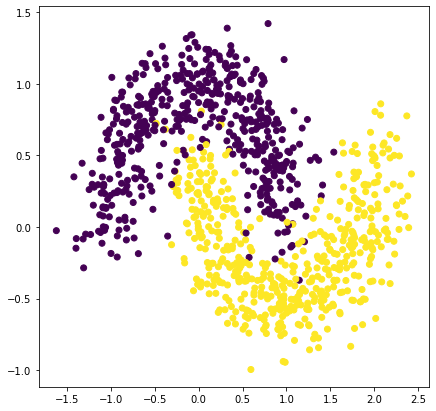

In [2]:
df = make_moons(n_samples=1000, noise=0.2, random_state=2)
df_x = [x[0] for x in df[0]]
df_y = [x[1] for x in df[0]]
df_group = df[1]

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(df_x, df_y, c=df_group)

Antes de aplicar ningún modelo, hemos de separar los datos entre el conjunto de *train* y el conjunto de *test*. Siempre trabajaremos sobre el conjunto de *train* y evaluaremos los resultados en *test*.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> divide el <i>dataset</i> en dos subconjuntos, <i>train</i> (80% aprox.) y <i>test</i>. Puedes servirte de <i>train_test_split</i>, ya implementado en <i>sklearn</i>.
</div>

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    df[0], 
    df[1], 
    test_size=0.2, 
    random_state=0
)

A lo largo de los ejercicios veremos gráficamente las fronteras de decisión asociadas a cada uno de los diferentes modelos. Para hacerlo utilizaremos la función definida a continuación. Dicha función sigue los siguientes pasos:

- Crear una [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) con los valores mínimos y máximos de 'x' e 'y'.
- Predecir con el clasificador los valores de la *meshgrid*.
- Hacer un *reshape* de los datos para tener el formato correspondiente.

Una vez hecho esto, ya podemos crear el gráfico de las fronteras de decisión y añadirle los puntos reales.
Así, veremos las áreas que el modelo considera que son de una clase y las que considera que son de otra. De esta forma, comprobaremos si el modelo clasifica los puntos correctamente dentro del área que les corresponde. También detectaremos las áreas de incertidumbre, casos en los que el modelo no se decanta ni por una clase ni por la otra (o si sí que se decanta por una pero no lo tiene 100% claro), éstas áreas serán blanquecinas.

In [23]:
# Hacemos la meshgrid con los valores máximos y mínimos de 'x' e 'y'.
x_min, x_max = min(df_x)-0.1, max(df_x)+0.1
y_min, y_max = min(df_y)-0.1, max(df_y)+0.1

def plot_decision_boundaries(x, y, labels, model, 
                             x_min=x_min, 
                             x_max=x_max, 
                             y_min=y_min, 
                             y_max=y_max, 
                             grid_step=0.02):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    
    # Predecimos los valores de la meshgrid con el clasificador.
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

    # Hacemos el reshape para tener el formato correcto.
    Z = Z.reshape(xx.shape)

    # Seleccionamos una paleta de color.
    arr = plt.cm.coolwarm(np.arange(plt.cm.coolwarm.N))
    arr_hsv = mpl.colors.rgb_to_hsv(arr[:,0:3])
    arr_hsv[:,2] = arr_hsv[:,2] * 1.5
    arr_hsv[:,1] = arr_hsv[:,1] * .5
    arr_hsv = np.clip(arr_hsv, 0, 1)
    arr[:,0:3] = mpl.colors.hsv_to_rgb(arr_hsv) 
    my_cmap = ListedColormap(arr)
    
    # Creamos el gráfico con las fronteras de decisión.
    fig, ax = plt.subplots(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=my_cmap, shading='auto')

    # Añadimos los puntos.
    ax.scatter(x, y, c=labels, cmap='coolwarm')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.grid(False)

### 1.1 $K$ vecinos más cercanos (1 punto)

El primer algoritmo que utilizaremos para clasificar los puntos es el $k$-nn. En este ejercicio, ajustaremos dos hiperparámetros del algoritmo con la intención de obtener una mayor precisión:

- $k$: el número de vecinos que se considera para clasificar un nuevo ejemplo. Probaremos con todos los valores entre 1 y 10.
- pesos: importancia que se da a cada uno de los vecinos considerados. En este caso, jugaremos con dos opciones: pesos uniformes, donde todos los vecinos se consideran de igual manera; y pesos en función de la distancia, donde los vecinos más cercanos tienen más peso en la clasificación que los vecinos más lejanos.

Para decidir cuáles son los hiperparámetros óptimos utilizaremos la técnica de búsqueda conocida como *grid search*, con la que entrenaremos un modelo para cada combinación de hiperparámetros posible y la evaluaremos utilizando validación cruzada (*cross validation*) con 4 particiones estratificadas. Posteriormente, elegiremos la combinación de hiperparámetres que mejores resultados haya obtenido.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> calcula el valor óptimo de los hiperparámetros <i>k</i> y <i>pesos</i>. Haz un <i>heatmap</i> para visualizar las precisiones de cada combinación según los dos hiperparámetros. Puedes utilizar los módulos GridSearchCV y KNeighborsClassifier de sklearn.
</div>

In [5]:
# Definimos los parámetros para GridSearchCV
parametros = {
    'n_neighbors': [k + 1 for k in range(10)],
    'weights': ['uniform', 'distance']
}

# Definimos el modelo de GridSearchCV
modelo_GridSearchCSV = GridSearchCV(
    KNeighborsClassifier(), 
    param_grid=parametros,
    scoring='accuracy',
    cv=4
)

# Ajustamos el modelo
modelo_GridSearchCSV = modelo_GridSearchCSV.fit(X_train, y_train)

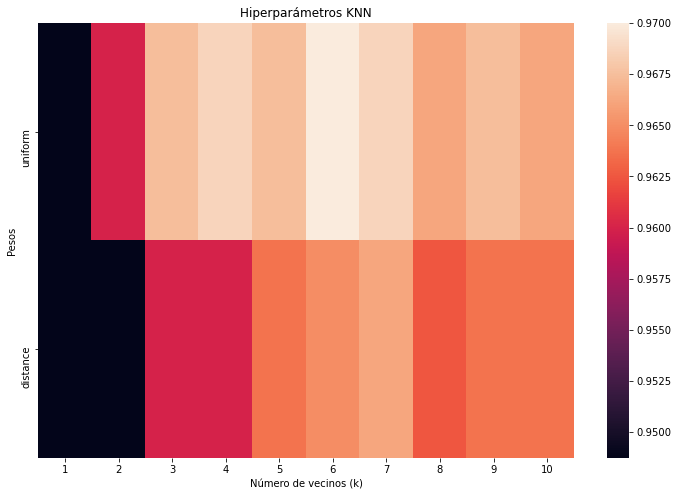

In [6]:
# Creación del mapa de calor para cada hiperparámetro
df_GridSearchCSV = pd.DataFrame(modelo_GridSearchCSV.cv_results_["params"])
df_GridSearchCSV["accuracy"] = modelo_GridSearchCSV.cv_results_["mean_test_score"]

data = {}
for k in range(1, 11):
    data[k] = np.array(df_GridSearchCSV[df_GridSearchCSV["n_neighbors"] == k]["accuracy"])

df_heatmap = pd.DataFrame(
    data,
    columns=np.unique(df_GridSearchCSV["n_neighbors"]),
    index=reversed(np.unique(df_GridSearchCSV["weights"]))
)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_heatmap)
plt.title("Hiperparámetros KNN")
plt.xlabel("Número de vecinos (k)")
plt.ylabel("Pesos")
plt.show()

In [7]:
print("El mejor número de vecinos (k) es: ", modelo_GridSearchCSV.best_params_["n_neighbors"])
print("El mejor peso es: ", modelo_GridSearchCSV.best_params_["weights"])
print("El accuracy obtenido con los mejores hiperparámetros es: ", modelo_GridSearchCSV.best_score_)

El mejor número de vecinos (k) es:  6
El mejor peso es:  uniform
El accuracy obtenido con los mejores hiperparámetros es:  0.97


<div class="alert alert-block alert-info">
<strong>Implementación:</strong> usando los hiperparámetros con mayor precisión, representa gráficamente la frontera de decisión con el <i>dataset</i> de test y calcula su <i>accuracy</i> y su matriz de confusión. 
</div>

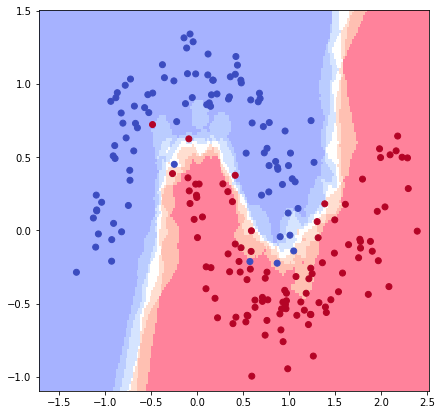

In [11]:
# Creación del modelo con los hiperparámetros con mayor precisión
modelo_knn = KNeighborsClassifier(
    n_neighbors=modelo_GridSearchCSV.best_params_["n_neighbors"],
    weights=modelo_GridSearchCSV.best_params_["weights"]
)

# Ajustamos el modelo
modelo_knn = modelo_knn.fit(X_train, y_train)

# Representación de la frontera de decisión
plot_decision_boundaries(
    X_test[:,0], 
    X_test[:,1], 
    y_test, 
    modelo_knn
)

El accuracy del modelo es:  0.97


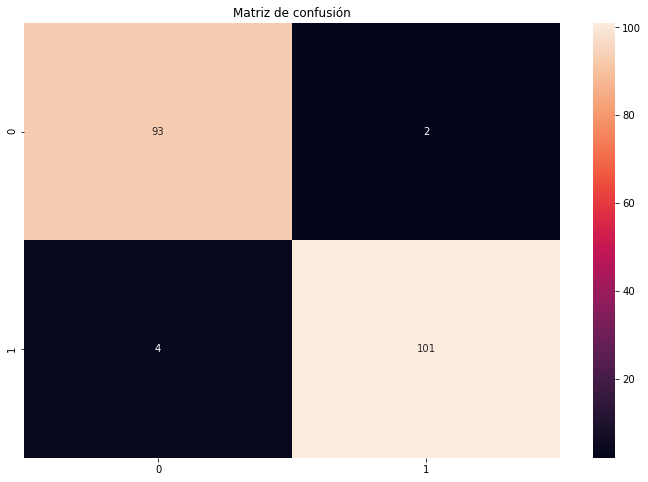

In [9]:
# Realizamos la predicción para el conjunto de test
y_pred = modelo_knn.predict(X_test)

# Calculamos el accuracy
print("El accuracy del modelo es: ", accuracy_score(y_test, y_pred))

# Calculamos la matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(matriz_confusion, annot=True, fmt='g',)
plt.title("Matriz de confusión")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> analiza los resultados obtenidos y en especial la frontera de descisión.
</div>

Lo primero destacar que la mejor precisión la obtenemos cuando el número de vecinos es igual a 6 y los pesos son uniformes, es decir, el número de vecinos es casi la mitad de todos los que se ha considerado (10) y cuando se da a todos los vecinos la misma importancia.

Creando el modelo con los valores indicados, luego ajustándolo con el dataset de train y prediciendo nuevas clasificaciones vemos que el modelo tiene un accuracy del 0.97, es decir, es capaz de clasificar de forma correcta el 97% de los datos nuevos. Observando la matriz de confusión, vemos que cuando la clase predicha es 0 y realmente es 1 tenemos 2 observaciones mal clasificadas, por contra, cuando la clase predicha es 1 pero realmente es 0 tenemos 4 observaciones mal clasificadas, es decir, en la gran mayoría de casos nuestro modelo se comporta de forma idónea.

Por lo que respecta a la frontera de decisión, vemos que una vez creado el modelo con los parámetros idóneos y ajustado con el conjunto de train, crea una frontera de decisión buena pero no bien definida, es decir, es capaz de generar dos áreas que permita diferenciar ambos semicírculos que hay en el problema. Visualizando los puntos del conjunto test, vemos que el modelo generado no es del todo preciso, ya que hay 2 puntos mal clasificaos (uno debería pertener a un conjunto y realmente es al otro y vicerversa), también hay unos pocos puntos que están en la zona fronteriaza, pero el modelo sí que es capaz de clasificarlos de forma general.

En resumen, el modelo se comporta de forma idónea para nuevos datos, es decir, se consigue clasificar nuevas observaciones sin cometer un gran error.

### 1.2. Support Vector Machines (1 punto)

En este segundo ejercicio, clasificaremos los puntos utilizando el algoritmo SVM con el *kernel* radial. Volveremos a utilizar *grid search*. En este caso los hiperparámetros a optimizar son:

- C: regularización, es decir, el valor de penalización de los errores en la clasificación. Indica el compromiso entre obtener el hiperplano con el margen más grande posible y clasificar el máximo número de ejemplos correctamente. Probaremos los valores: 0.01, 0.1, 1, 10, 50, 100 y 200.
- gamma: coeficiente que multiplica la distancia entre dos puntos al kernel radial. A "grosso modo", cuanto más pequeña es gamma, más influencia tienen los puntos cercanos. Probaremo los valores: 0.001, 0.01, 0.1, 1 y 10.

Igual que en el caso anterior, para validar el rendimiento del algoritmo con cada combinación de hiperparámetros utilizaremos validación cruzada (*cross-validation*) con 4 particiones estratificadas.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> calcula el valor óptimo de los hiperparámetros <i>C</i> y <i>gamma</i>. Haz un <i>heatmap</i> para visualizar las precisiones de cada combinación según los dos hiperparámetros. Puedes utilizar los módulos GridSearchCV y SVC de sklearn.
</div>

In [35]:
# Definimos los parámetros para GridSearchCV
parametros = {
    'C': [0.01, 0.1, 1, 10, 50, 100, 200],
    'gamma': [0.001, 0.01, 0.1, 1, 10]
}

# Definimos el modelo de GridSearchCV
modelo_GridSearchCSV = GridSearchCV(
    svm.SVC(kernel="rbf", random_state=0), 
    param_grid=parametros,
    scoring='accuracy',
    cv=4
)

# Ajustamos el modelo
modelo_GridSearchCSV = modelo_GridSearchCSV.fit(X_train, y_train)

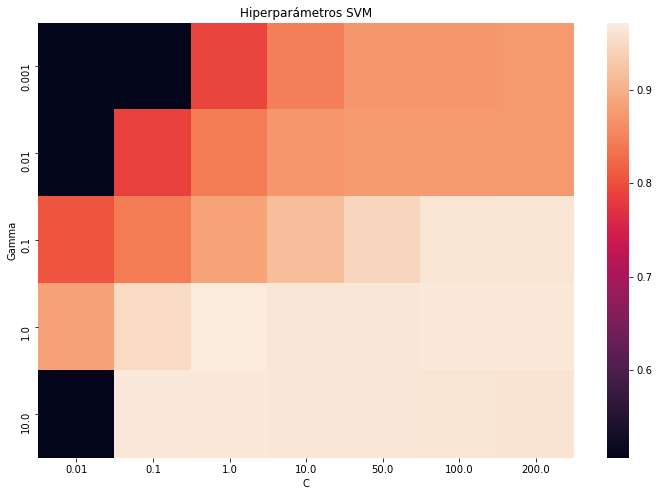

In [36]:
# Creación del mapa de calor para cada hiperparámetro
df_GridSearchCSV = pd.DataFrame(modelo_GridSearchCSV.cv_results_["params"])
df_GridSearchCSV["accuracy"] = modelo_GridSearchCSV.cv_results_["mean_test_score"]

data = {}
for c in np.unique(df_GridSearchCSV["C"]):
    data[c] = np.array(df_GridSearchCSV[df_GridSearchCSV["C"] == c]["accuracy"])

df_heatmap = pd.DataFrame(
    data,
    columns=np.unique(df_GridSearchCSV["C"]),
    index=np.unique(df_GridSearchCSV["gamma"])
)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_heatmap)
plt.title("Hiperparámetros SVM")
plt.xlabel("C")
plt.ylabel("Gamma")
plt.show()

In [37]:
print("La mejor C es: ", modelo_GridSearchCSV.best_params_["C"])
print("La mejor gamma es: ", modelo_GridSearchCSV.best_params_["gamma"])
print("El accuracy obtenido con los mejores hiperparámetros es: ", modelo_GridSearchCSV.best_score_)

La mejor C es:  1
La mejor gamma es:  1
El accuracy obtenido con los mejores hiperparámetros es:  0.97125


<div class="alert alert-block alert-info">
<strong>Implementación:</strong> usando los hiperparámetros con mayor precisión, representa gráficamente la frontera de decisión con el <i>dataset</i> de test y calcula su <i>accuracy</i> y su matriz de confusión. 
</div>

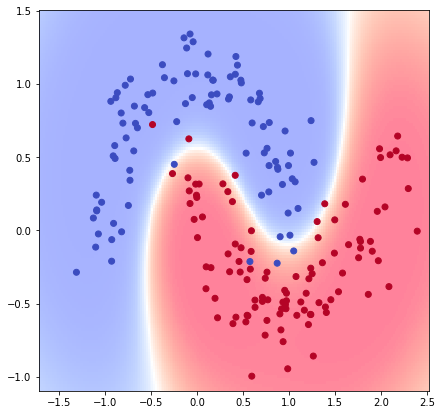

In [39]:
# Creación del modelo con los hiperparámetros con mayor precisión
modelo_svm = svm.SVC(
    kernel="rbf",
    probability=True,
    random_state=0,
    C=modelo_GridSearchCSV.best_params_["C"],
    gamma=modelo_GridSearchCSV.best_params_["gamma"]
)

# Ajustamos el modelo
modelo_svm = modelo_svm.fit(X_train, y_train)

# Representación de la frontera de decisión
plot_decision_boundaries(
    X_test[:,0], 
    X_test[:,1], 
    y_test, 
    modelo_svm
)

El accuracy del modelo es:  0.955


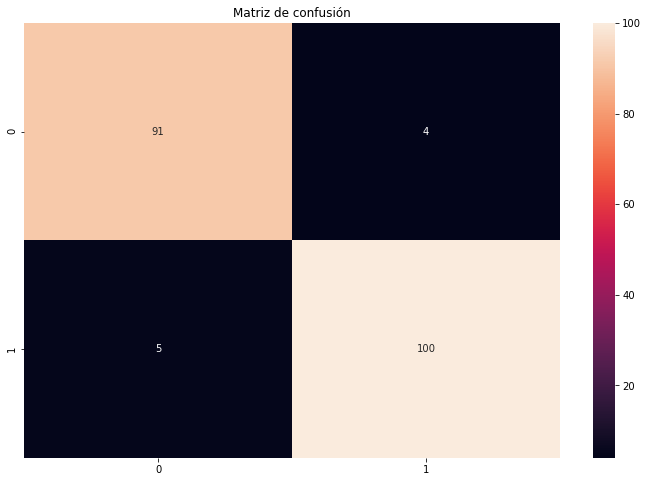

In [40]:
# Realizamos la predicción para el conjunto de test
y_pred = modelo_svm.predict(X_test)

# Calculamos el accuracy
print("El accuracy del modelo es: ", accuracy_score(y_test, y_pred))

# Calculamos la matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(matriz_confusion, annot=True, fmt='g',)
plt.title("Matriz de confusión")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> analiza los resultados obtenidos y en especial la frontera de descisión.
</div>

En cuanto al modelo que mejor se comporta con nuestros datos, se caracteriza porque tanto el parámetro C como gamma son iguales a 1.

Creando el modelo con esta configuración de parámetros vemos que una vez ajustado el modelo obtenemos un accuracy de 0.955, es decir, el modelo es capaz de clasificar correctamente el 95% de los datos. A la vista de la matriz de confusión vemos que clasifica de forma errónea 9 observaciones, 4 obsercaciones (cuando la clase es 0 y realmente es 1) y 5 observaciones (cuando la clase es 1 y realmente es 0).

Respecto a la frontera de decisión, vemos que está muchísimo mejor definida que en el modelo anterior, es decir, la zona fronteriza entre una área y otra es menor y encima está más ajustada, esto nos permite ver que este modelo es más preciso (calcula mejor las áreas). Sin embargo, vemos que el accuracy es algo menor para los datos que se predicen, es decir, con los datos de entrenamiento se comporta mejor este modelo, pero a la hora de predecir se comporta algo mejor el KNN.

En resumen, aunque para el conjunto de test el modelo KNN se comporta un poco mejor que el SVM, es verdad que éste último consigue hacer que la frontera de decisión sea menor, por lo que a priori a mayor número de datos mejor se va a comporta el modelo SVM respecto al KNN, aunque en nuestro caso sucede lo contrario.

### 1.3. Árboles de decisión (1 punto)

En este tercer ejercicio, clasificaremos los puntos utilizando un árbol de decisión. Utilizaremos como antes *grid search* para ajustar los hiperparámetros. En este caso ajustaremos los siguientes:

- max_depth: la profundidad máxima del árbol. Exploraremos los valores entre 4 y 10. 
- min_samples_split: el mínimo número de observaciones que ha de tener una hoja del árbol para poderse dividir. Exploraremos los valores: 2, 10, 20, 50 y 100.

Igual que en los casos anteriores, utilizaremos validación cruzada (*cross-validation*) con 4 particiones estratificadas para validar el rendimiento del algoritmo con cada combinación de hiperparámetros.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> calcula el valor óptimo de los hiperparámetros <i>max_depth</i> y <i>min_samples_split</i>. Haz un <i>heatmap</i> para visualizar las precisiones de cada combinación según los dos hiperparámetros. Puedes utilizar los módulos GridSearchCV y DecisionTreeClassifier de sklearn.
</div>

In [48]:
# Definimos los parámetros para GridSearchCV
parametros = {
    'max_depth': [x for x in range(4,11)],
    'min_samples_split': [2, 10, 20, 50, 100]
}

# Definimos el modelo de GridSearchCV
modelo_GridSearchCSV = GridSearchCV(
    DecisionTreeClassifier(random_state=0), 
    param_grid=parametros,
    scoring='accuracy',
    cv=4
)

# Ajustamos el modelo
modelo_GridSearchCSV = modelo_GridSearchCSV.fit(X_train, y_train)

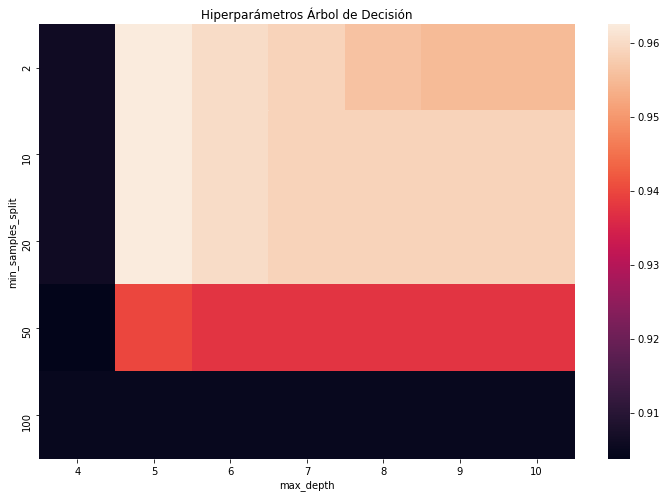

In [49]:
# Creación del mapa de calor para cada hiperparámetro
df_GridSearchCSV = pd.DataFrame(modelo_GridSearchCSV.cv_results_["params"])
df_GridSearchCSV["accuracy"] = modelo_GridSearchCSV.cv_results_["mean_test_score"]

data = {}
for m_d in np.unique(df_GridSearchCSV["max_depth"]):
    data[m_d] = np.array(df_GridSearchCSV[df_GridSearchCSV["max_depth"] == m_d]["accuracy"])
    
df_heatmap = pd.DataFrame(
    data,
    columns=np.unique(df_GridSearchCSV["max_depth"]),
    index=np.unique(df_GridSearchCSV["min_samples_split"])
)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_heatmap)
plt.title("Hiperparámetros Árbol de Decisión")
plt.xlabel("max_depth")
plt.ylabel("min_samples_split")
plt.show()

In [50]:
print("El mejor max_depth es: ", modelo_GridSearchCSV.best_params_["max_depth"])
print("El mejor min_samples_split es: ", modelo_GridSearchCSV.best_params_["min_samples_split"])
print("El accuracy obtenido con los mejores hiperparámetros es: ", modelo_GridSearchCSV.best_score_)

El mejor max_depth es:  5
El mejor min_samples_split es:  2
El accuracy obtenido con los mejores hiperparámetros es:  0.9624999999999999


<div class="alert alert-block alert-info">
<strong>Implementación:</strong> usando los hiperparámetros con mayor precisión, representa gráficamente la frontera de decisión con el <i>dataset</i> de test y calcula su <i>accuracy</i> y su matriz de confusión. 
</div>

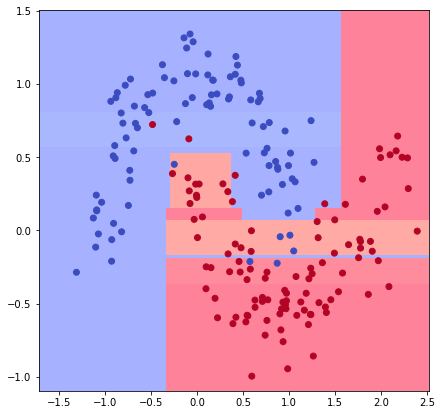

In [54]:
# Creación del modelo con los hiperparámetros con mayor precisión
modelo_dtc = DecisionTreeClassifier(
    random_state=0,
    max_depth=modelo_GridSearchCSV.best_params_["max_depth"],
    min_samples_split=modelo_GridSearchCSV.best_params_["min_samples_split"]
)

# Ajustamos el modelo
modelo_dtc = modelo_dtc.fit(X_train, y_train)

# Representación de la frontera de decisión
plot_decision_boundaries(
    X_test[:,0], 
    X_test[:,1], 
    y_test, 
    modelo_dtc
)

El accuracy del modelo es:  0.945


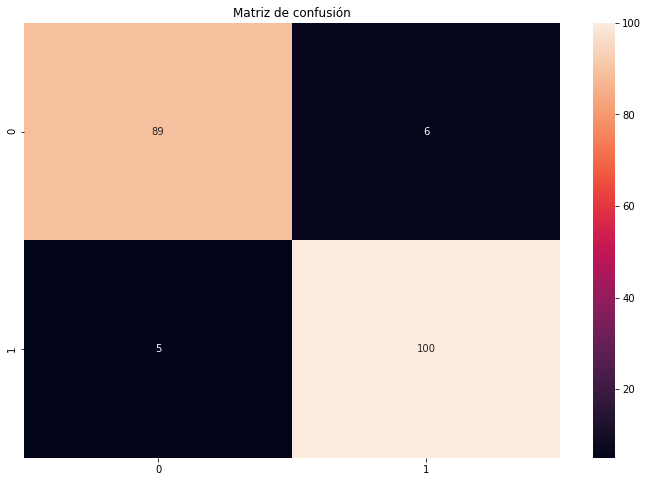

In [55]:
# Realizamos la predicción para el conjunto de test
y_pred = modelo_dtc.predict(X_test)

# Calculamos el accuracy
print("El accuracy del modelo es: ", accuracy_score(y_test, y_pred))

# Calculamos la matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(matriz_confusion, annot=True, fmt='g',)
plt.title("Matriz de confusión")
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> analiza los resultados obtenidos y en especial la frontera de descisión.
</div>

El modelo que proporciona un mayor accuracy es con los parámetros:
- max_depth = 5
- min_samples_split = 2  

Una vez creado el modelo y ajustado con los datos de entrenamiento, hemos obtenido un accuracy del 0.945, es decir, para nuevos datos el modelo es capaz de clasificar correctamente el 94.5% de las nuevas observaciones, comete 6 errores cuando la clase predicha es 0 y realmente es 1, y comete 5 errores cuando la clase predicha es 1 pero realmente es 0.

Respecto a la frontera de decisión vemos que ha cambiado completamente si la comparamos con KNN y SVM, es decir, en este caso los cortes que se realizan en el plano son ortogonales, por ejemplo en SVM al calcular un hiperplano alejado de las dos dimensiones es capaz de definir una línea fronteriza adaptada de una mejor forma a los datos, y de manera similar sucede con KNN. Aun así vemos que este modelo no se comporta mal del todo, su accuracy es 0.945, pero éste es menor que en los casos de KNN y SVM.

En resumen, en este caso vemos que ha cambiado la forma de definir la frontera de decisión, para ello se hacen cortes ortogonales en el plano. Comparando este modelo con los anteriores vemos que es un pelín peor en cuanto a la precisión del mismo para nuevos datos, pero éste no se comporta mal del todo.

### 1.4. Random forest (1 punto)

En este cuarto ejercicio, clasificaremos los puntos utilizando Random forest. Utilizaremos, como hasta ahora, *grid search* para ajustar los hiperparámetros y ajustaremos:

- max_depth: la profundidad máxima del árbol. Exploraremos los valores comprendidos entre 6 y 12. 
- n_estimators: número de árboles. Exploraremos los valores: 10, 50, 100 y 200.

Igual que en los casos anteriores, utilizaremos validación cruzada (*cross-validation*) con 4 particiones estratificadas para validar el rendimiento del algoritmo con cada combinación de hiperparámetros.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> calcula el valor óptimo de los hiperparámetros <i>max_depth</i> y <i>n_estimators</i>. Haz un <i>heatmap</i> para visualizar las precisiones de cada combinación según los dos hiperparámetros. Puedes utilizar los módulos GridSearchCV y RandomForestClassifier de sklearn.
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> usando los hiperparámetros con mayor precisión, representa gráficamente la frontera de decisión con el <i>dataset</i> de test y calcula su <i>accuracy</i> y su matriz de confusión. 
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> analiza los resultados obtenidos y en especial la frontera de descisión.
</div>

### 1.5. Gradient boosting (1 punto)

En este ejercicio clasificaremos los puntos utilizando Gradient boosting. Emplearemos como hasta ahora *grid search* para ajustar los siguientes hiperparámetros:

- learning_rate: velocidad de aprendizaje. Si su valor es muy alto, correremos el riesgo de no encontrar el valor óptimo por más que el algoritmo busque; mientras que si el valor es muy bajo, éste puede tardar mucho en converger y estancarse en un mínimo local. Exploraremos los valores: 0.01, 0.1, 1 y 2. 
- n_estimators: número de árboles. Exploraremos los valores: 10, 50, 100 y 200.

Igual que en los casos anteriores, utilizaremos validación cruzada (*cross-validation*) con 4 particiones estratificadas para validar el rendimiento del algoritmo con cada combinación de hiperparámetros.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> calcula el valor óptimo de los hiperparámetros <i>learning_rate</i> y <i>n_estimators</i>. Haz un <i>heatmap</i> para visualizar las precisiones de cada combinación según los dos hiperparámetros. Puedes utilizar los módulos GridSearchCV y GradientBoostingClassifier de sklearn.
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> usando los hiperparámetros con mayor precisión, representa gráficamente la frontera de decisión con el <i>dataset</i> de test y calcula su <i>accuracy</i> y su matriz de confusión. 
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> analiza los resultados obtenidos y en especial la frontera de descisión.
</div>

# 2. Implementación de un caso práctico (5 puntos)

Ahora que ya entendemos cómo funcionan algunos modelos, vamos a aplicarlos a un caso práctico. La primera mitad de la práctica se ha realizado utilizando una variable objetivo categórica, para esta segunda mitad emplearemos una variable objetivo numérica. Es decir, trabajaremos con un problema de regresión, no de clasificación.

Utilizaremos un conjunto de datos público de precios de viviendas en Taiwán con el objetivo de encontrar las mejores ofertas del mercado. La descripción completa del conjunto de datos la podemos encontrar en el siguiente enlace: https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set

Comencemos cargando los datos en un DataFrame de pandas:

In [25]:
dataset = pd.read_excel('Real estate valuation data set.xlsx', engine='openpyxl')

dataset.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


La primera columna ("*No*") es el identificador numérico de la muestra. Las columnes "*Xn ...*" son los diferentes atributos descriptivos. Finalmente, la columna "*Y ...*" es el valor objetivo o precio de la vivienda.

Extraemos del *DataFrame* la variable objetivo y los atributos descriptivos que utilizaremos posteriormente en el modelo predictivo:

In [26]:
X = dataset[[
    'X2 house age',
    'X3 distance to the nearest MRT station',
    'X4 number of convenience stores',
    'X5 latitude',
    'X6 longitude'
]]

y = dataset['Y house price of unit area']

### 2.1. Análisis descriptivo
Cuando se nos proporciona un dataset, antes de comenzar a hacer nada, es muy importante hacer un análisis exploratorio para conocer los datos con los que trabajaremos.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> analizar gráficamente la distribución de todas las variables (features y target). Recuerda que las variables categóricass se representan con gráficas de barras, mientras que las numéricas se representan con histogramas.
</div>

### 2.2. Preprocesamiento de los datos

Una vez hecho un primer análisis, se trata de "limpiar" el dataset (las features) y adaptarlo a nuestras necesidades (en este caso, predecir el precio de una vivienda).

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> comprueba si hay valores nulos. En caso de haberlos, elimina las filas correspondientes.
</div>

El siguiente paso sería estudiar la correlación entre todas las variables descriptivas (features) numéricas. Esto se hace para asegurarse de que no hay dos variables muy relacionadas entre sí, ya que en tal caso sería conveniente seleccionar una de las dos o combinarlas en una nueva para reducir dimensionalidad.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> muestra la correlación entre todas las features numéricas. Si hay dos con una correlación superior al 90%, elimina una de ellas.
    
Puedes utilizar heatmap, de seaborn, para verlas en un mapa de colores.
</div>

Ya tenemos las variables finales con las que trabajaremos. Vamos a observar ahora cuál es la relación de cada una de ellas con el target.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> realiza varios scatterplots cruzando los diferentes atributos descriptivos con la variable target. Se ha de realizar un scatterplot por atributo.
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿qué atributos tienen correlación positiva? ¿Cuáles negativa? ¿Cuáles no tienen ninguna correlación? Analiza cada uno de los gráficos. ¿Tiene sentido que la relación de cada atributo con el target sea la encontrada?
</div>

### 2.3. Entrenamiento de un modelo

Ahora que ya tenemos el dataset limpio y hemos hecho un análisis de las diferentes variables, podemos proceder a entrenar un modelo para predecir el precio de una vivienda. Probaremos con 2 modelos diferentes e interpretaremos sus resultados. Para comenzar, separemos el dataset en train y test.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> divide el <i>dataset</i> en dos subconjuntos, <i>train</i> (80% de los datos) y <i>test</i> (20% restante). Nombraremos los conjuntos: X_train, X_test, y_train e y_test. Utilizaremos la opción random_state=24.
    
Puedes servirte de la implementación <i>train_test_split</i> de <i>sklearn</i>.
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> utiliza un árbol de decisión simple con max_depth=5 para modelar el dataset sobre el conjunto de train. Dibuja el árbol de decisión. Si te queda muy grande, dibuja un árbol entrenado con menor profundidad para que puedas apreciarlo mejor. Utiliza alguna medida de error (puedes escoger la que quieras: MAE, RMSE, ...) para estimar cómo de bien lo ha hecho el modelo prediciedo en train y en test. También servirá para poder comparar a posteriori con otro modelo.
    
Para dibujar el árbol puedes guiarte con este enlace: https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc. Towardsdatascience es un blog que te deja leer unos cuantos artículos gratuitamente y despues te pide subscripción. Si fuera el caso y ya hubieras llegado al límite, puedes abrir el enlace en una pestaña de navegación privada.
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> interpreta el árbol de decisión, ¿qué variables son las que han tenido más peso? ¿Has obtenido una buena precisión evaluando en test? ¿Se ha producido overfitting?
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> utiliza Random Forest o Gradient Boosting para modelar el dataset. Esta vez vamos a optimizar el modelo para obtener los mejores resultados posibles. Tal y como hemos visto anteriormente, recuerda seguir los siguientes pasos:
    
  - Utilizar el dataset de train para encontrar los mejores hiperparámetros haciendo cross-validation.
  - Entrenar el modelo con train, predecir con train y test y calcular el error (MAE, RMSE, ...)
</div>

Un Random Forest / Gradient Boosting no es tan fácil de interpretar como un simple Decision Tree. No podemos dibujar un árbol porque son combinaciones de muchos árboles, pero sí que podemos saber cuáles han sido las variables más decisivas a la hora de generar el modelo. Para saberlo, no podremos hacerlo mirando cómo se divide el árbol, sino que se lo tendremos que consultar al modelo através de la "feature importance" de éste.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> muestra cada variable del modelo aprendido junto con su feature importance.
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> interpreta el clasificador, ¿cuáles son las variables que han tenido más peso? ¿Has obtenido una buena precisión evaluando en test? ¿Se ha producido overfitting?
</div>

### 2.4. Predicción de casos nuevos

Hasta ahora hemos entrenado un modelo y hemos evaluado en test para hacernos una idea de la precisión de nuestro modelo con datos reales. Ahora vamos a utilizarlo.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 
    
  - Caso 1: queremos comprar una vivienda que está situada a 1km de la estación de tren, concretamente sus coordenadas son: 24.87745, 121.31683. La vivienda tiene 3 tiendas cerca y se construyó hace 15 años. Se vende por 24500€/m2 y queremos saber si está por encima o por debajo del precio de mercado.	
    
  - Caso 2: somos una empresa que se dedica a hacer negocio comprando pisos baratos, arreglándolos y volviéndolos a vender más caros. Queremos saber qué viviendas del conjunto de datos se venden por debajo de su precio de mercado ("chollos") para poder comprarlas y revenderlas en un futuro.
</div>